In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os

def plot_metric(
    df,
    df_expert,
    metric,
    group_tag,
    split_tag,
    barWidth=0.25,
    rotation=0,
    figure_dir=None,
):
    # Initialize the plot
    plt.figure(figsize=(5, 5))
    color_palette = sns.color_palette("colorblind", n_colors=5)

    # Unique method and judge_models
    unique_splits = df[split_tag].unique()
    unique_groups = df[group_tag].unique()
    num_splits = len(unique_splits)

    # Position of bars on x-axis
    ind = np.arange(num_splits)

    df_expert = (
        df_expert.set_index(split_tag).reindex(unique_splits).reset_index()
    )

    df_expert[metric] *= 100
    yerr = df_expert["std_err"] * 100

    # Plot bars
    bar_positions = ind
    # use dotted line
    plt.bar(
        bar_positions,
        df_expert[metric],
        width=barWidth*4,
        label="Oracle",
        yerr=yerr,
        linewidth=0.5,
        edgecolor="#757575",
        linestyle="-",
        capsize=7,
        align="edge",
        color="#E0E0E0",
        hatch="//",
    )

    # Loop through each qa_xex_model to plot bars
    for i, model in enumerate(['Blind', 'Consultancy', 'Debate', 'Interactive Debate']):
        model_data = df[df[group_tag] == model]
        model_data = (
            model_data.set_index(split_tag).reindex(unique_splits).reset_index()
        )

        model_data[metric] *= 100
        yerr = model_data["std_err"] * 100

        # Plot bars
        bar_positions = ind + i * barWidth
        plt.bar(
            bar_positions,
            model_data[metric],
            width=barWidth,
            label=model,
            yerr=yerr,
            linewidth=1,
            edgecolor="black",
            capsize=7,
            align="edge",
            color=color_palette[i],
        )

    plt.ylabel(f"Judge Accuracy (%)", fontsize=16)
    n = len(unique_groups)
    center_for_group = ind + n * barWidth / 2
    plt.xticks(center_for_group, unique_splits, rotation=rotation, fontsize=16)
    plt.legend(title="Protocol", fontsize=16, title_fontsize=16, ncol=1, bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.yticks(fontsize=16)
    plt.grid(True, which="both", linewidth=0.5, axis="y")
    plt.gca().set_axisbelow(True)  # To place grid lines behind bars
    plt.xlabel("Judge", fontsize=16)

    # make y ticks be every 10
    plt.yticks(np.arange(0, 110, 25))
    plt.ylim(0, 100)


    # save figure
    if figure_dir:
        plt.savefig(f"{figure_dir}/minimal.png", dpi=300, bbox_inches="tight")

    plt.show()

In [2]:
judge_name_map = {
    "gpt-3.5-turbo": "GPT-3.5-Turbo",
    "claude-2.1": "Claude 2.1",
    "gpt-4-1106-preview": "GPT-4-Turbo",
}
protocol_name_map = {
    "baseline_blind": "Blind",
    "consultancy_correct_intermediary": "Consultancy",
    "consultancy_incorrect_intermediary": "Consultancy",
    "debate_sim": "Debate",
    "debate_sim_intermediary": "Interactive Debate",
    "baseline_oracle": "Expert",
}

# load data
whoami = os.getenv("USER")
csv =f"./exp/minimal/results.csv"
df = pd.read_csv(csv)

# cleanup
df = df.drop(columns=['dataset', 'n_votes', 'debate_type', 'method_type', 'consultant_type', 'use_intermediary', 'seed', 'exp_suffix', 'accuracy_N', 'unknown_proportion'])
df = df[df.iloc[:, 0] != df.columns[0]]
df.fillna("None", inplace=True)
df["accuracy"] = df["accuracy"].astype(float)
df["num_matches"] = df["num_matches"].astype(int)
df = df.drop_duplicates()

# rename columns and convert values
df.rename(columns={"method": "Protocol", "model": "Judge"}, inplace=True)
df["Protocol"] = df["Protocol"].map(protocol_name_map)
df["Judge"] = df["Judge"].map(judge_name_map)

# average over consultancy assignments
df = df.groupby(["Protocol", "Judge", "swap"]).agg({"accuracy": "mean", "num_matches": "sum"}).reset_index()
# average over swap
df = df.groupby(["Protocol", "Judge"]).agg({"accuracy": "mean", "num_matches": "sum"}).reset_index()
# calculate std error
df["std_err"] = np.sqrt(df["accuracy"] * (1 - df["accuracy"]) / df["num_matches"])

df


,Protocol,Judge,accuracy,num_matches,std_err
0,Blind,GPT-4-Turbo,0.4250,40,0.078162
1,Consultancy,GPT-4-Turbo,0.6875,80,0.051822
2,Debate,GPT-4-Turbo,0.7250,40,0.070600
3,Expert,GPT-4-Turbo,0.8500,40,0.056458
4,Interactive Debate,GPT-4-Turbo,0.8000,40,0.063246


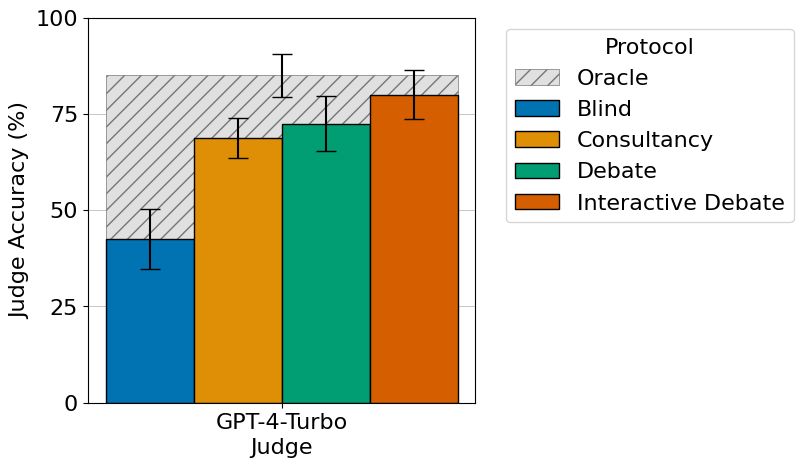

In [3]:
plot_metric(
    df[df["Protocol"] != "Expert"],
    df[df["Protocol"] == "Expert"],
    "accuracy",
    split_tag="Judge",
    group_tag="Protocol",
    barWidth=0.15,
)